<a href="https://colab.research.google.com/github/aaronhallaert/DeepLearningLab/blob/main/Final_Project/Final_Project_Voting_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Voting Analysis

## Imports and Drive Management

In [1]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import os
import re
import pickle

# fix random seed for reproducibility
seed = 2021
np.random.seed(seed)  


from pathlib import Path

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import load_model

2.4.1


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import random

# path to google drive zip
path_to_zip = '/content/gdrive/My Drive/Colab Notebooks/DL2021/Final_Project/shared/artists_recognition_dataset.zip'
# local path to data zip
local_path_to_folder = '/content/artists_recognition_dataset'

# download zip if it does not yet exist in local environment
if not Path(local_path_to_folder.replace(".zip", "")).exists():
  print("Downloading dataset to local environment...")
  !rsync --info=progress2 "{path_to_zip}" .
  print("Extracting dataset in local environment...")
  !unzip -q artists_recognition_dataset.zip | awk 'BEGIN {ORS=" "} {if(NR%10==0)print "."}'
  print("Removing zip to save space...")
  !rm artists_recognition_dataset.zip
else:
  print("Dataset already present in local environment")

# path to folder with images
path = '/content/artists_recognition_dataset/resized/resized'
images_dir = Path(path)

### PARSE DATASET ###

# key = path_to_image:Path
# value = artist:str
painting_artist_dict = {}

# key = artist:str
# value = path_to_image:Path
artist_painting_dict = {}

for image in images_dir.rglob("*"):
  if image.is_file() and str(image).endswith("jpg"):
        # Extract label from filename
        pattern= re.compile(r"(.*)_(\d*).jpg$")
        match = pattern.match(str(image.name))
        artist = match.group(1)
        instance = match.group(2)

        painting_artist_dict[str(image)] = artist
        if artist not in list(artist_painting_dict.keys()):
          artist_painting_dict[artist] = []
        artist_painting_dict[artist].append(image)


print("Loading the predefined splits")
df_test_orig = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/DL2021/Final_Project/shared/test_split.csv")
df_train_orig = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/DL2021/Final_Project/shared/train_split.csv")
df_validate_orig = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/DL2021/Final_Project/shared/validate_split.csv")

painting_artist_dict_test = dict(zip(df_test_orig.filename, df_test_orig.label))
artist_painting_dict_test = {k: g["filename"].tolist() for k,g in df_test_orig.groupby("label")}

painting_artist_dict_train = dict(zip(df_train_orig.filename, df_train_orig.label))
artist_painting_dict_train = {k: g["filename"].tolist() for k,g in df_train_orig.groupby("label")}

painting_artist_dict_validate = dict(zip(df_validate_orig.filename, df_validate_orig.label))
artist_painting_dict_validate = {k: g["filename"].tolist() for k,g in df_validate_orig.groupby("label")}

classes = sorted(list(artist_painting_dict.keys()))
n_classes = len(classes)
assert n_classes == 50, "Number of classes (%d) should be 50, check Albrecht_Durer images" % n_classes

Dataset already present in local environment
Loading the predefined splits


## Preprocess images

### Make Slices

In [4]:
from PIL import Image
import progressbar
import sys
import time
import math

def make_sliced_dataset(a_p_dict, p_a_dict):
    start = time.time()

    new_artist_painting_dict = {}
    new_painting_artist_dict = {}

    total = len(list(p_a_dict.keys()))
    count = 0

    for artist, paintings in a_p_dict.items():


        for painting_idx, painting_file in enumerate(paintings):

            count += 1
            # Only start slicing if the painting has not been sliced yet
            slices_path = Path(painting_file).parent.parent.joinpath("slices")
            slices_path.mkdir(exist_ok=True)

            pattern= re.compile(r"(.*)_(\d*).jpg$")
            match = pattern.match(str(painting_file))
            instance = int(match.group(2))

            img = plt.imread(painting_file)

            # Some images are grayscale, some are color

            rows = img.shape[0]
            cols = img.shape[1]

            min_dim = min(rows, cols)
            max_dim = max(rows, cols)
            nr_cutouts = math.ceil(max_dim/min_dim)

            # if not slices_path.joinpath("%s_%d_%d.jpg" % (artist, painting_idx, 0)).exists():

            img_slices = []

            if max_dim/min_dim > 1.15:

                offset = int(((nr_cutouts * min_dim) - max_dim)/(nr_cutouts-1))
                if rows > cols:
                    for i in range(nr_cutouts):
                        start_idx = int((min_dim * i) - (offset * i))
                        img_slices.append(img[start_idx:start_idx+min_dim,:])

                elif cols > rows:
                    for i in range(nr_cutouts):
                        start_idx = int((min_dim * i) - (offset * i))
                        img_slices.append(img[:,start_idx:start_idx+min_dim])

                else:
                    img_slices.append(img)

            else:
                img_slices.append(img)


            for index, slice in enumerate(img_slices):
                slice_path = Path(painting_file).parent.parent.joinpath("slices").joinpath("%s_%d_%d.jpg" % (artist, instance, index))

                if not slice_path.exists():
                    # if index == 0:
                    #     print("sliced %s painting %d" % (artist, painting_idx))
                    
                    print("\r %d / %d" % (count, total), end = '', flush = True)
                    Image.fromarray(slice).save(slice_path)

                new_painting_artist_dict[str(slice_path)] = artist
                if artist not in list(new_artist_painting_dict.keys()):
                  new_artist_painting_dict[artist] = []
                new_artist_painting_dict[artist].append(slice_path)


    stop = time.time()
    print("execution time: " + str(stop-start) + " ms")

    return new_artist_painting_dict, new_painting_artist_dict


# Slicing for validate set
print("Slice validate date")
artist_painting_dict_validate, painting_artist_dict_validate = make_sliced_dataset(artist_painting_dict_validate, painting_artist_dict_validate)

# Slicing for test set
print("Slice test date")
artist_painting_dict_test, painting_artist_dict_test = make_sliced_dataset(artist_painting_dict_test, painting_artist_dict_test)

Slice validate date
execution time: 8.363122463226318 ms
Slice test date
execution time: 10.158045768737793 ms


### Group slices to original painting

In [5]:
# painting - list of patches
def create_painting_patches_dict(p_a_dict):
  painting_patches_dict = {}


  for key in list(p_a_dict.keys()):
    pattern= re.compile(r"(.*)\_(\d*)\.jpg$")
    match = pattern.match(str(key))
    painting = match.group(1) + ".jpg"

    if painting not in painting_patches_dict:
      painting_patches_dict[painting] = []
    
    painting_patches_dict[painting].append(key)
  
  return painting_patches_dict

print(painting_artist_dict_validate)

painting_patches_dict_validate = create_painting_patches_dict(painting_artist_dict_validate)
painting_patches_dict_test = create_painting_patches_dict(painting_artist_dict_test)


{'/content/artists_recognition_dataset/resized/slices/Albrecht_Durer_128_0.jpg': 'Albrecht_Durer', '/content/artists_recognition_dataset/resized/slices/Albrecht_Durer_45_0.jpg': 'Albrecht_Durer', '/content/artists_recognition_dataset/resized/slices/Albrecht_Durer_45_1.jpg': 'Albrecht_Durer', '/content/artists_recognition_dataset/resized/slices/Albrecht_Durer_169_0.jpg': 'Albrecht_Durer', '/content/artists_recognition_dataset/resized/slices/Albrecht_Durer_169_1.jpg': 'Albrecht_Durer', '/content/artists_recognition_dataset/resized/slices/Albrecht_Durer_206_0.jpg': 'Albrecht_Durer', '/content/artists_recognition_dataset/resized/slices/Albrecht_Durer_206_1.jpg': 'Albrecht_Durer', '/content/artists_recognition_dataset/resized/slices/Albrecht_Durer_269_0.jpg': 'Albrecht_Durer', '/content/artists_recognition_dataset/resized/slices/Albrecht_Durer_269_1.jpg': 'Albrecht_Durer', '/content/artists_recognition_dataset/resized/slices/Albrecht_Durer_283_0.jpg': 'Albrecht_Durer', '/content/artists_rec

## Making Predictions

In [6]:
# loading model
from keras.models import model_from_json


checkpoint_dir = "/content/gdrive/My Drive/Colab Notebooks/DL2021/Final_Project/saved_models/"
load_model_json = checkpoint_dir+"30_04_finetuning_test75.json"
load_model_h5 = checkpoint_dir+"30_04_finetuning_test75.h5"

# load json and create model
json_file = open(load_model_json, 'r')
loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json)

# compile model
model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1), 
              metrics=['accuracy']) 

json_file.close()

model.load_weights(load_model_h5)

print("Loaded model from disk")

Loaded model from disk


In [32]:
def compute_predictions(p_p_dict, p_a_dict, mode):
  all_predictions = {}
  
  count = 0
  good = 0
  bad = 0
  total = len(list(p_p_dict.keys()))
  print(total)
  for painting in list(p_p_dict.keys()):


    ### create label array ###
    label = p_a_dict[painting.replace("slices", "resized")]
    class_idx = classes.index(label)

    label_array = np.zeros(n_classes)
    label_array[class_idx] = 1

    ### create prediction array ###
    patches = p_p_dict[painting]
    patch_predictions = []
    for patch in patches:
      # load image 
      patch_img = Image.open(patch) 
      patch_img = patch_img.convert('RGB')
      patch_img = patch_img.resize((256,256))
      patch_img = tf.keras.preprocessing.image.img_to_array(patch_img)
      patch_img = np.expand_dims(patch_img, axis=0)

      prediction = model.predict(patch_img)
      patch_predictions.append(prediction)
    

    prediction_array = []
    ##### MEAN VOTING #####
    if mode is "mean":
      prediction_array = np.mean(patch_predictions, axis=0)

    ##### MAJORITY VOTING #####
    elif mode is "majority":

      # convert to ones and zeros
      for patch_pred_idx, patch_pred in enumerate(patch_predictions):
        max_idx = np.argmax(patch_pred)
        patch_pred = np.zeros(n_classes)
        patch_pred[max_idx] = 1

        patch_predictions[patch_pred_idx] = patch_pred 

      voted_predictions = sum(patch_predictions)
      print(voted_predictions)

      max_voted_idx = np.argmax(voted_predictions)
      prediction_array = np.zeros(n_classes)
      prediction_array[max_voted_idx] = 1

    ##### MOST SURE VOTING #####
    elif mode is "most_sure":

      most_sure_patch = -1
      current_highest = -1
      # find most sure patch
      for patch_pred_idx, patch_pred in enumerate(patch_predictions):
        pred_prob = np.amax(patch_pred)
        if pred_prob > current_highest:
          current_highest = pred_prob
          most_sure_patch = patch_pred_idx

      prediction_array = patch_predictions[most_sure_patch]

    prediction_idx = np.argmax(prediction_array)
    if prediction_idx == class_idx:
      good += 1
    else:
      bad += 1

    count+=1
    print("\r %d / %d: %d good, %d bad" % (count, total, good, bad), end = '', flush = True)

    all_predictions[painting] = [label_array, prediction_array]

  return all_predictions
print("VALIDATE PREDICTIONS")
validate_predictions = compute_predictions(painting_patches_dict_validate, painting_artist_dict, "most_sure")
print("")
print("TEST PREDICTIONS")
test_predictions = compute_predictions(painting_patches_dict_test, painting_artist_dict, "most_sure")

VALIDATE PREDICTIONS
1337
 1337 / 1337: 983 good, 354 bad
TEST PREDICTIONS
1671
 1671 / 1671: 1210 good, 461 bad

## Analysis

### Declare functions

In [33]:
from sklearn.metrics import accuracy_score

def get_ytrue_ypred(predictions_dict):
  y_true = []
  y_pred = []
  for i in range(0, len(list(predictions_dict.values()))):
    # y_true.append(list(predictions_dict.values())[i][0])

    y_true.append(np.argmax(list(predictions_dict.values())[i][0]))

    pred = np.zeros(50)
    pred[ np.argmax(list(predictions_dict.values())[i][1][0]) ]=1
    # y_pred.append(pred)

    y_pred.append(np.argmax(list(predictions_dict.values())[i][1][0]))
  return y_true, y_pred

def calc_accuracy(predictions_dict):
  y_true, y_pred = get_ytrue_ypred(predictions_dict)
  return accuracy_score(y_true, y_pred)


In [34]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(predictions_dict):
  y_true, y_pred = get_ytrue_ypred(predictions_dict)

    
  fig, ax = plt.subplots(figsize=(30,30))
  min_val, max_val = 0, 1
  intersection_matrix = confusion_matrix(y_true, y_pred, normalize='true')
  ax.matshow(intersection_matrix, cmap=plt.cm.Blues)
  for i in range(0,50):
      for j in range(0,50):
          c = "{0:,.2f}".format(intersection_matrix[j,i])
          ax.text(i, j, str(c), va='center', ha='center')


  ax.set_xticks(range(0,n_classes))
  ax.set_yticks(range(0,n_classes))
  ax.set_xticklabels(classes, rotation = 90)
  ax.set_yticklabels(classes)
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Actual")



In [35]:
from sklearn.metrics import classification_report

def print_classification_report(predictions_dict):
  y_true, y_pred = get_ytrue_ypred(predictions_dict)
  print(classification_report(y_true, y_pred, target_names=classes))



### Validation Analysis

Validate Accuracy: 0.7352281226626777
                           precision    recall  f1-score   support

           Albrecht_Durer       0.80      0.98      0.88        52
            Alfred_Sisley       0.68      0.83      0.75        41
        Amedeo_Modigliani       1.00      0.90      0.95        31
            Andrei_Rublev       1.00      0.56      0.72        16
              Andy_Warhol       0.76      0.86      0.81        29
         Camille_Pissarro       1.00      0.53      0.70        15
               Caravaggio       0.35      0.78      0.48         9
             Claude_Monet       0.00      0.00      0.00        12
             Diego_Rivera       1.00      0.36      0.53        11
          Diego_Velazquez       1.00      0.17      0.29         6
              Edgar_Degas       0.78      0.94      0.85       112
            Edouard_Manet       0.00      0.00      0.00        14
             Edvard_Munch       0.47      0.73      0.57        11
                 El_Gre

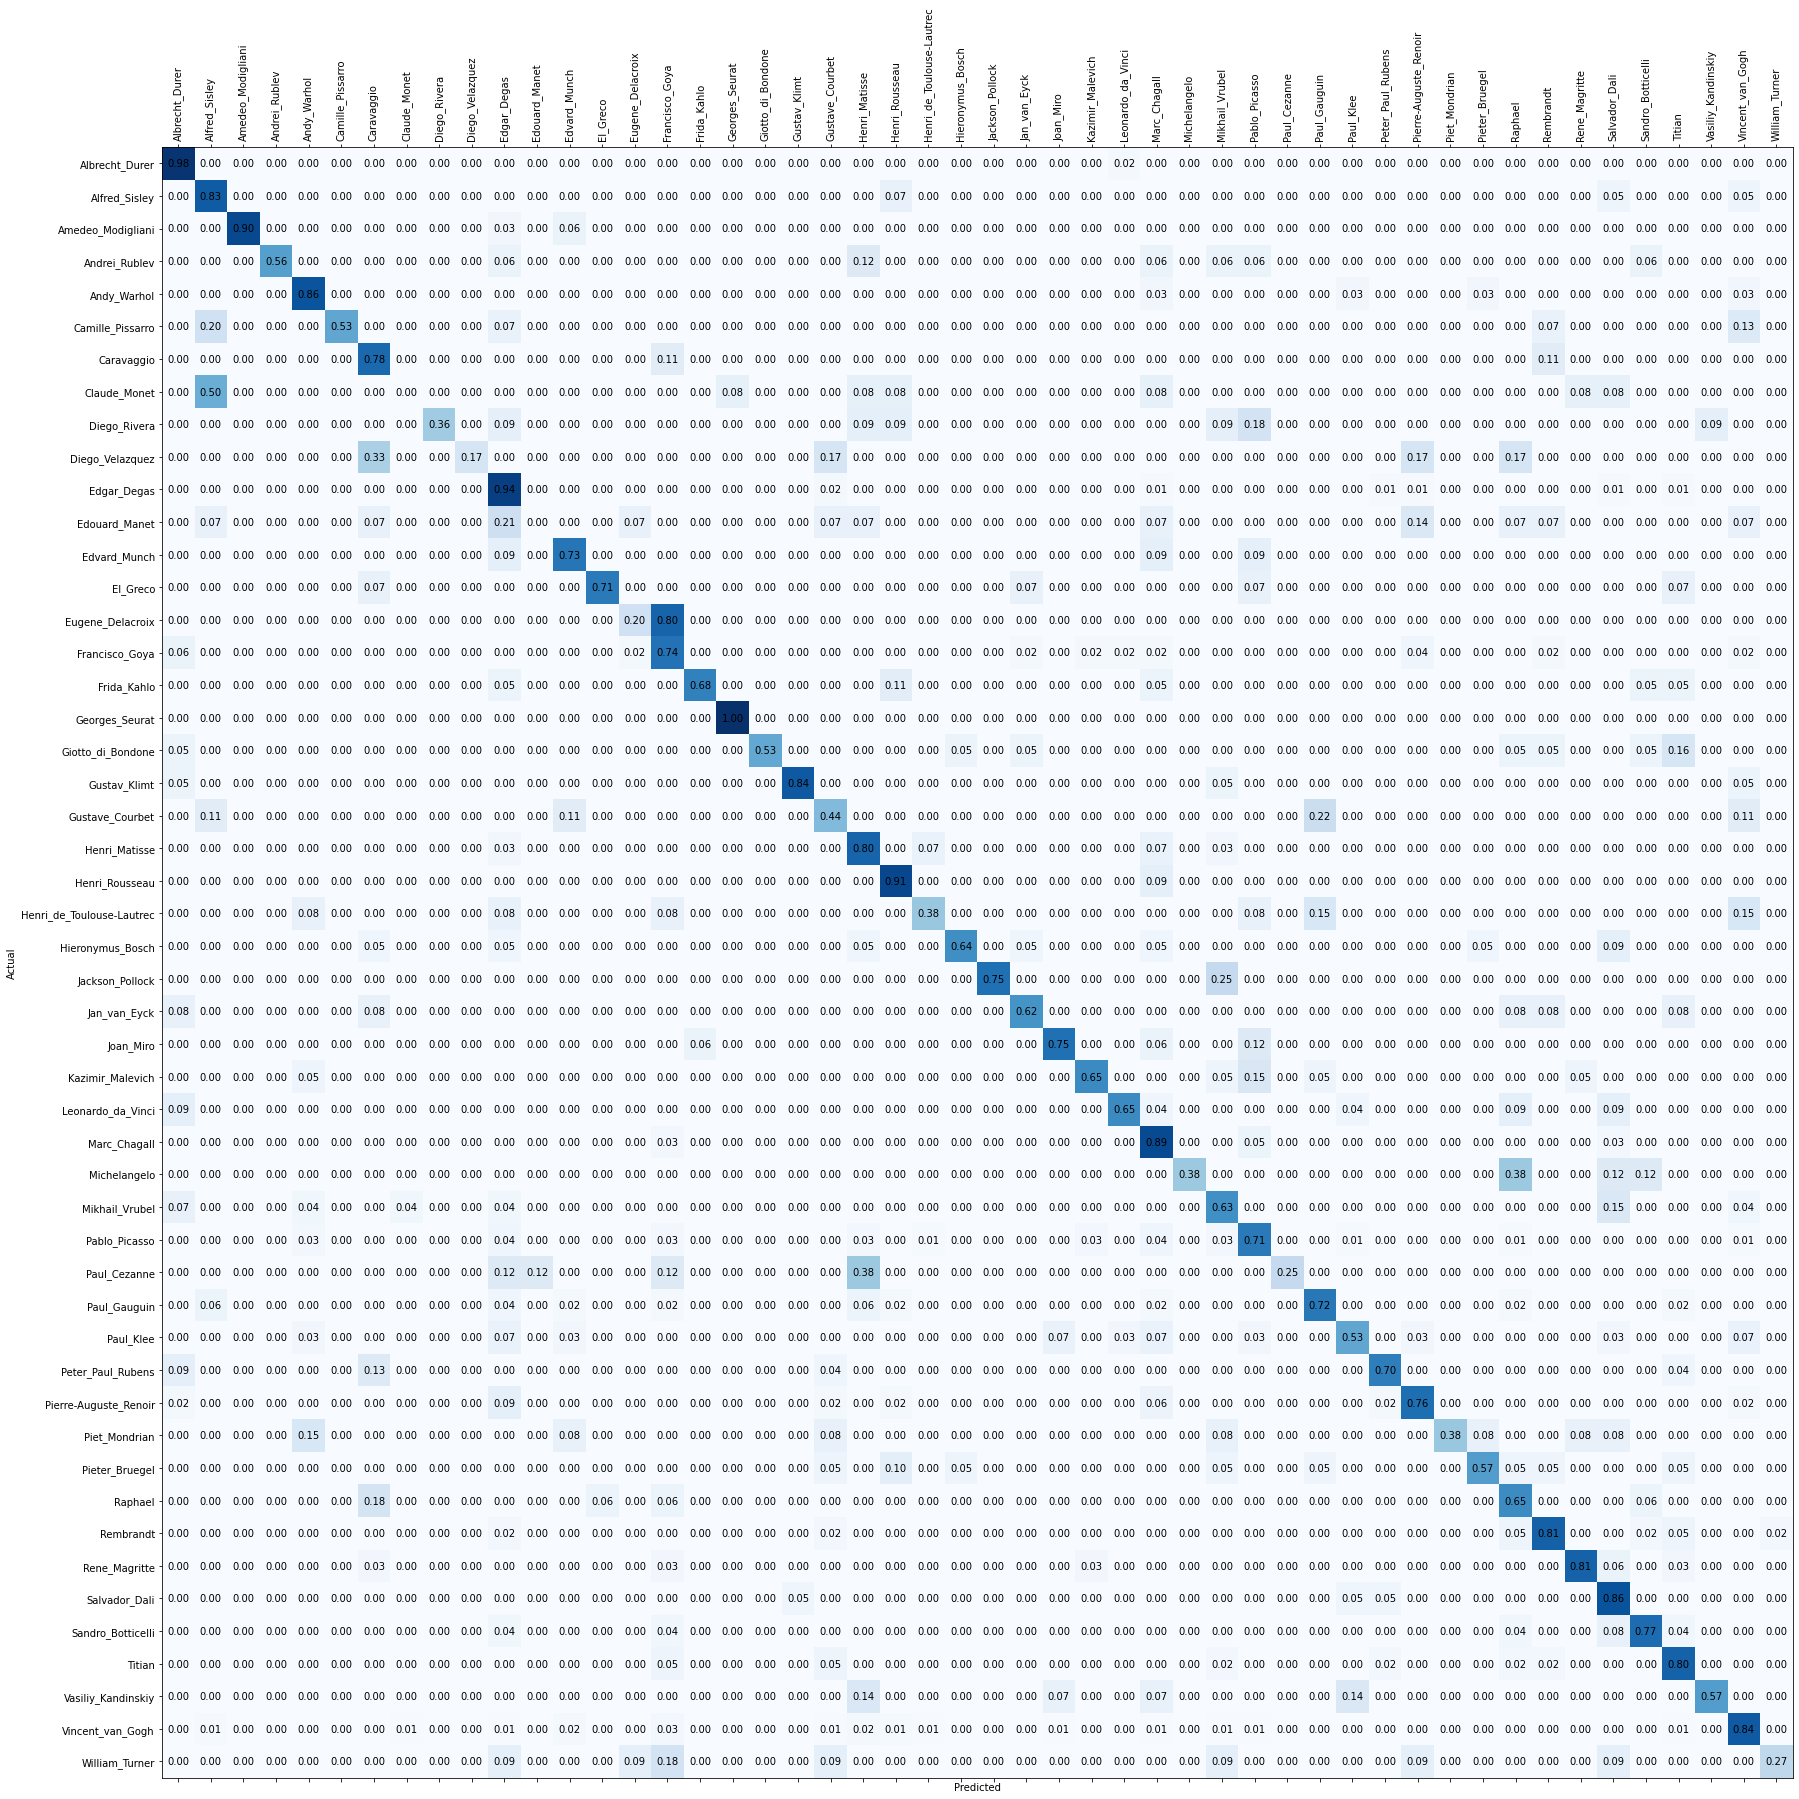

In [36]:
print("Validate Accuracy:", (calc_accuracy(validate_predictions)))
print_confusion_matrix(validate_predictions)
print_classification_report(validate_predictions)

### Test Analysis

Test Accuracy: 0.7241172950329144
                           precision    recall  f1-score   support

           Albrecht_Durer       0.74      0.95      0.83        66
            Alfred_Sisley       0.77      0.90      0.83        52
        Amedeo_Modigliani       0.94      0.77      0.85        39
            Andrei_Rublev       1.00      0.70      0.82        20
              Andy_Warhol       0.76      0.72      0.74        36
         Camille_Pissarro       0.75      0.50      0.60        18
               Caravaggio       0.32      0.91      0.48        11
             Claude_Monet       0.40      0.13      0.20        15
             Diego_Rivera       1.00      0.36      0.53        14
          Diego_Velazquez       1.00      0.14      0.25         7
              Edgar_Degas       0.78      0.94      0.85       140
            Edouard_Manet       1.00      0.11      0.20        18
             Edvard_Munch       0.47      0.69      0.56        13
                 El_Greco  

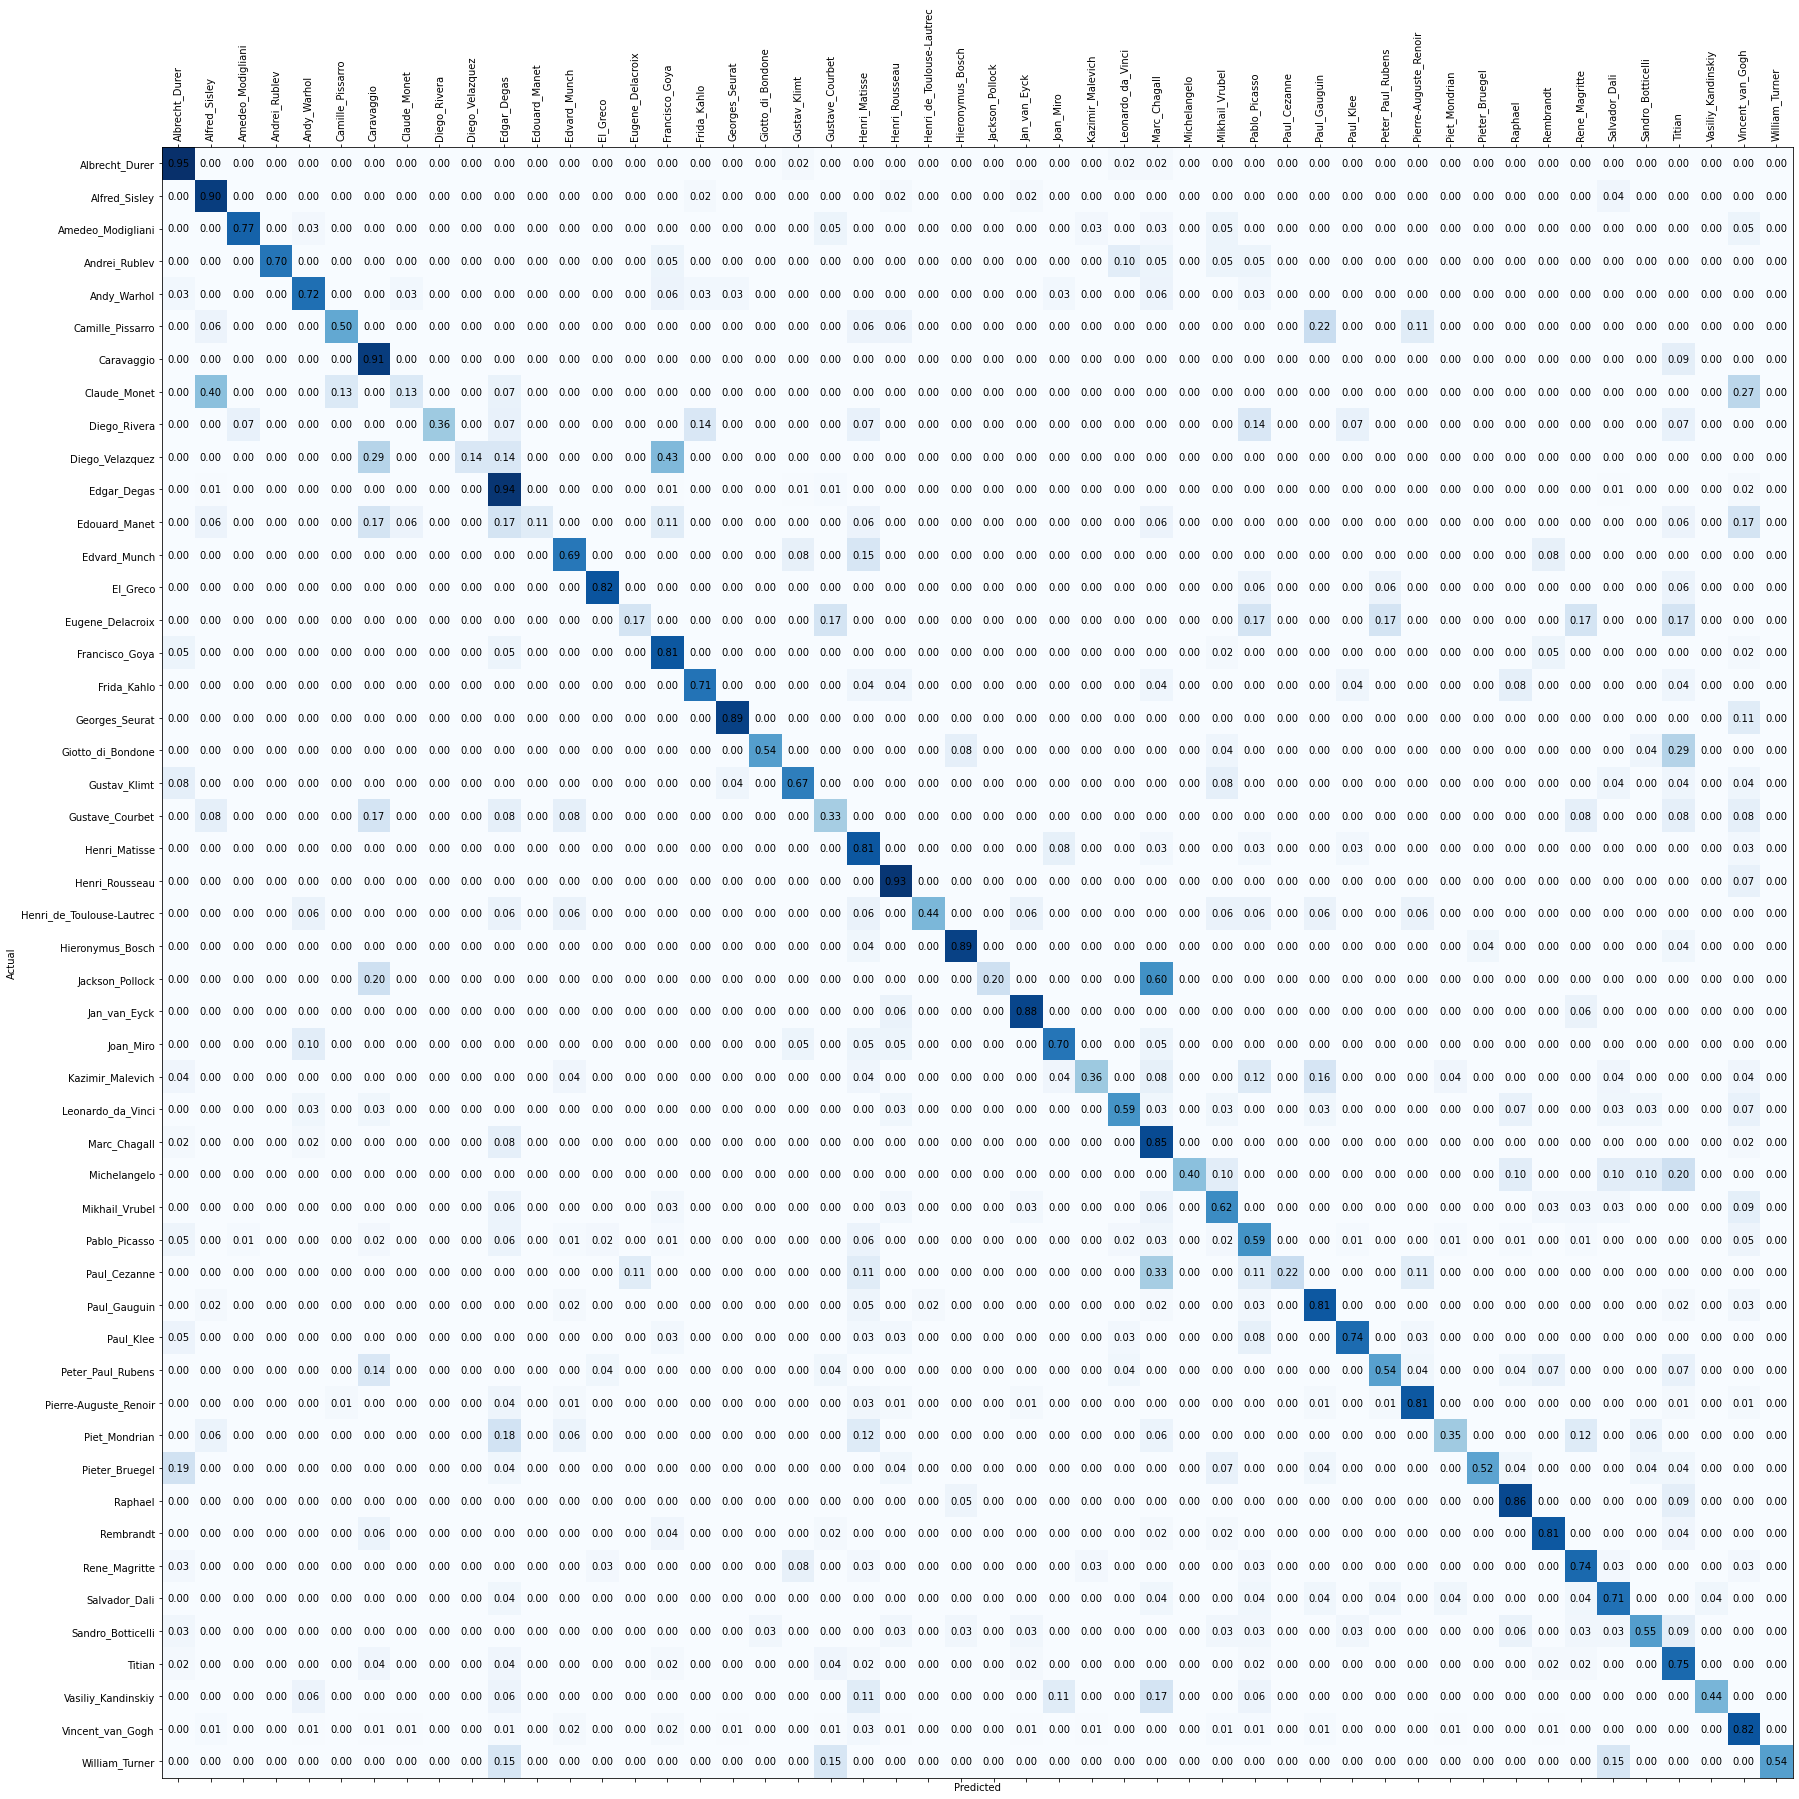

In [37]:
print("Test Accuracy:", (calc_accuracy(test_predictions)))
print_confusion_matrix(test_predictions)
print_classification_report(test_predictions)